# SGD fit tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.append("../src")

from stochastic_glv_generator import *
from experiments import *
from analysis import *
from inference import *

In [2]:
for i, a in enumerate(np.array([[1, 2], [2, 3]])):
    print(i, a)

0 [1 2]
1 [2 3]


In [3]:
n = 2
seed = 12345
r_max = 1.
A_diag_std = 2.
A_off_diag_std = 1.

p = sort_glv_params(n, seed, r_max, A_diag_std, A_off_diag_std)
r = p[:n]
A = p[n:].reshape((n, n))
x_eq = -np.linalg.inv(A)@r
print(x_eq)

env_noise = 0.0
t0 = 0
dt = 1e-2

np.random.seed(123)

# init_cond_list = init_cond_by_growth(x_eq, 0.1, 1)
init_cond_list = init_cond_by_perturb(x_eq, 2, [[-1, 1]], 1)

t_samp_list = np.linspace(0, 20, 10).reshape((1,-1))

meas_noise_list = np.array([0.0])
repetitions = 1

replicates = gen_replicates(p, env_noise, init_cond_list, t0, dt, t_samp_list, meas_noise_list, repetitions, seed=0, scale_meas_noise_by_abund=True, save_datasets=True)

[0.33151878 0.42426662]
1/1                                                                                                 

In [4]:
add_time_diff(replicates)
add_log_time_diff(replicates)

In [5]:
replicates

,dataset,measurement_noise,time,dt,sp1,sp2,dsp1/dt,dsp2/dt,dlogsp1/dt,dlogsp2/dt
0,0.0,0.0,0.000000,2.222222,0.078104,0.423487,6.100616e-02,-5.497887e-02,4.528847e-01,-1.531700e-01
1,0.0,0.0,2.222222,2.222222,0.213673,0.301311,4.518976e-02,3.124913e-02,1.733616e-01,9.332741e-02
2,0.0,0.0,4.444444,2.222222,0.314094,0.370754,8.118732e-03,2.010006e-02,2.513295e-02,5.118895e-02
3,0.0,0.0,6.666667,2.222222,0.332136,0.415421,-3.679190e-06,3.792345e-03,-1.107749e-05,9.037562e-03
4,0.0,0.0,8.888889,2.222222,0.332128,0.423848,-2.226943e-04,2.476733e-04,-6.710076e-04,5.839654e-04
5,0.0,0.0,11.111111,2.222222,0.331633,0.424399,-4.714302e-05,-4.214187e-05,-1.421766e-04,-9.930881e-05
6,0.0,0.0,13.333333,2.222222,0.331528,0.424305,-4.632122e-06,-1.501225e-05,-1.397224e-05,-3.538220e-05
7,0.0,0.0,15.555556,2.222222,0.331518,0.424272,1.723217e-07,-2.170801e-06,5.197955e-07,-5.116565e-06
8,0.0,0.0,17.777778,2.222222,0.331518,0.424267,1.514534e-07,-9.364200e-08,4.568473e-07,-2.207150e-07
9,0.0,0.0,20.000000,NaN,0.331519,0.424267,NaN,NaN,NaN,NaN


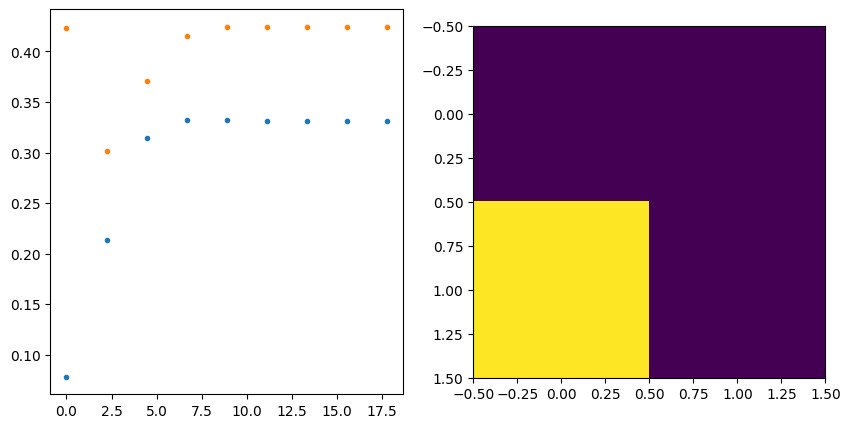

In [6]:
t = replicates.dropna()["time"].values
dt_arr = replicates.dropna()["dt"].values
y = replicates.dropna()[[i for i in replicates.columns if i[:2]=="sp"]].values
dydt = replicates.dropna()[[i for i in replicates.columns if i[:3]=="dsp"]].values
dlogydt = replicates.dropna()[[i for i in replicates.columns if i[:6]=="dlogsp"]].values

plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t, y, ".")
plt.subplot(1, 2, 2)
plt.imshow(np.sign(A))
plt.show()

0.75


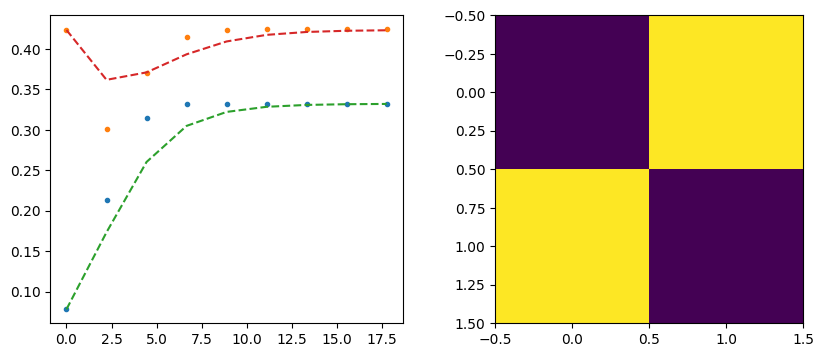

In [7]:
preg = fit_ridge_cv(replicates)
preg = np.concatenate((preg[0], preg[1].flatten()))

sol_reg = euler_maruyama(glv, t[0], y[0], preg, 0., dt, t)
plt.subplots(1, 2, figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(t, y, ".")
plt.plot(t, sol_reg, "--")
plt.subplot(1, 2, 2)
plt.imshow(np.sign(preg[n:].reshape((n,n))))

print((np.sign(preg[n:])==np.sign(p[n:])).sum()/n**2)

In [8]:
p0_list = np.random.normal(0, 2, (100, n*(n+1)))

p_lm = lm_fit(glv_for_fit, y, dydt.flatten(), p0_list)

100%|██████████| 100/100 [00:00<00:00, 1259.56it/s]


0.75


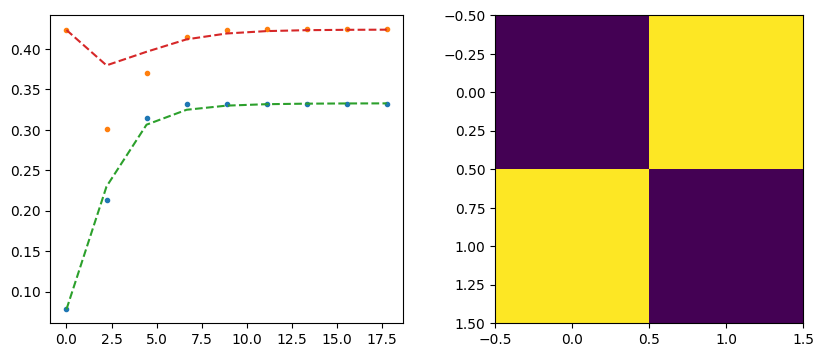

In [9]:
sol3 = euler_maruyama(glv, t[0], y[0], p_lm[-17], 0., dt, t)
plt.subplots(1, 2, figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(t, y, ".")
plt.plot(t, sol3, "--")
plt.subplot(1, 2, 2)
plt.imshow(np.sign(p_lm.mean(0)[n:].reshape((n,n))))

print((np.sign(p_lm.mean(0)[n:])==np.sign(p[n:])).sum()/n**2)

In [10]:
p

array([ 0.92961609,  0.31637555, -2.09290788, -0.5557303 ,  1.96578057,
       -2.28174615])

In [11]:
preg

array([ 0.47274526,  0.35850482, -1.77730684,  0.27816541,  0.59855352,
       -1.31599033])

In [12]:
p_lm[0]

array([ 0.5732302 ,  0.38446352, -2.88105418,  0.9094959 ,  0.5097958 ,
       -1.30688066])

In [13]:
dt_arr.reshape((-1,1)) * y * (r + np.dot(y, A.T))

array([[ 9.21288933e-02, -4.67133245e-01],
       [ 1.49557055e-01,  3.27379361e-02],
       [ 4.62110302e-02,  7.23793966e-02],
       [ 2.67474529e-03,  1.97533148e-02],
       [-7.69316538e-04,  2.02714921e-03],
       [-2.30287599e-04, -7.20828242e-05],
       [-3.03392802e-05, -6.47663484e-05],
       [-8.08896547e-07, -1.20711130e-05],
       [ 5.75664765e-07, -9.83549562e-07]])

In [14]:
mse(glv_for_fit(y, *preg), dydt.flatten())

4.6420301991483205e-05

In [15]:
mse(glv_for_fit(y, *p_lm[0]), dydt.flatten())

5.128566933826347e-06

In [16]:
mse(euler_maruyama(glv, t[0], y[0], p, 0., dt, t), y)

0.0

In [17]:
mse(euler_maruyama(glv, t[0], y[0], preg, 0., dt, t), y)

0.0005442733710787013

In [18]:
mse(euler_maruyama(glv, t[0], y[0], p_lm[0], 0., dt, t), y)

0.0004025566227837291

/home/valeriano/Documents/BEPE/gLV_OED/notebooks/../src/stochastic_glv_generator.py:75: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  rhs_time[i] = x[i] * (r + np.dot(A, x[i]))
/tmp/ipykernel_4066/2928885897.py:5: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(F))


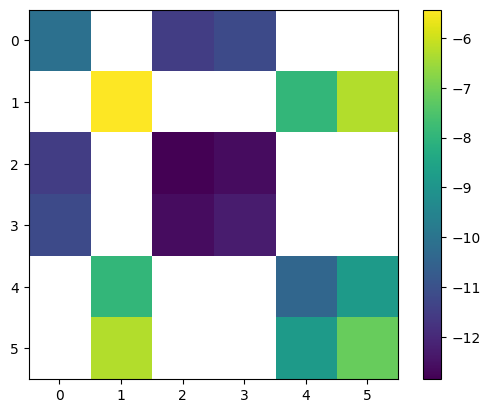

In [19]:
S = np.expand_dims(glv_time(t, y, p)-dydt, axis=-1)*glv_jac_time(t, y, p)
S = np.concatenate(S, 0)
F = S.T@S

plt.imshow(np.log(F))
plt.colorbar()

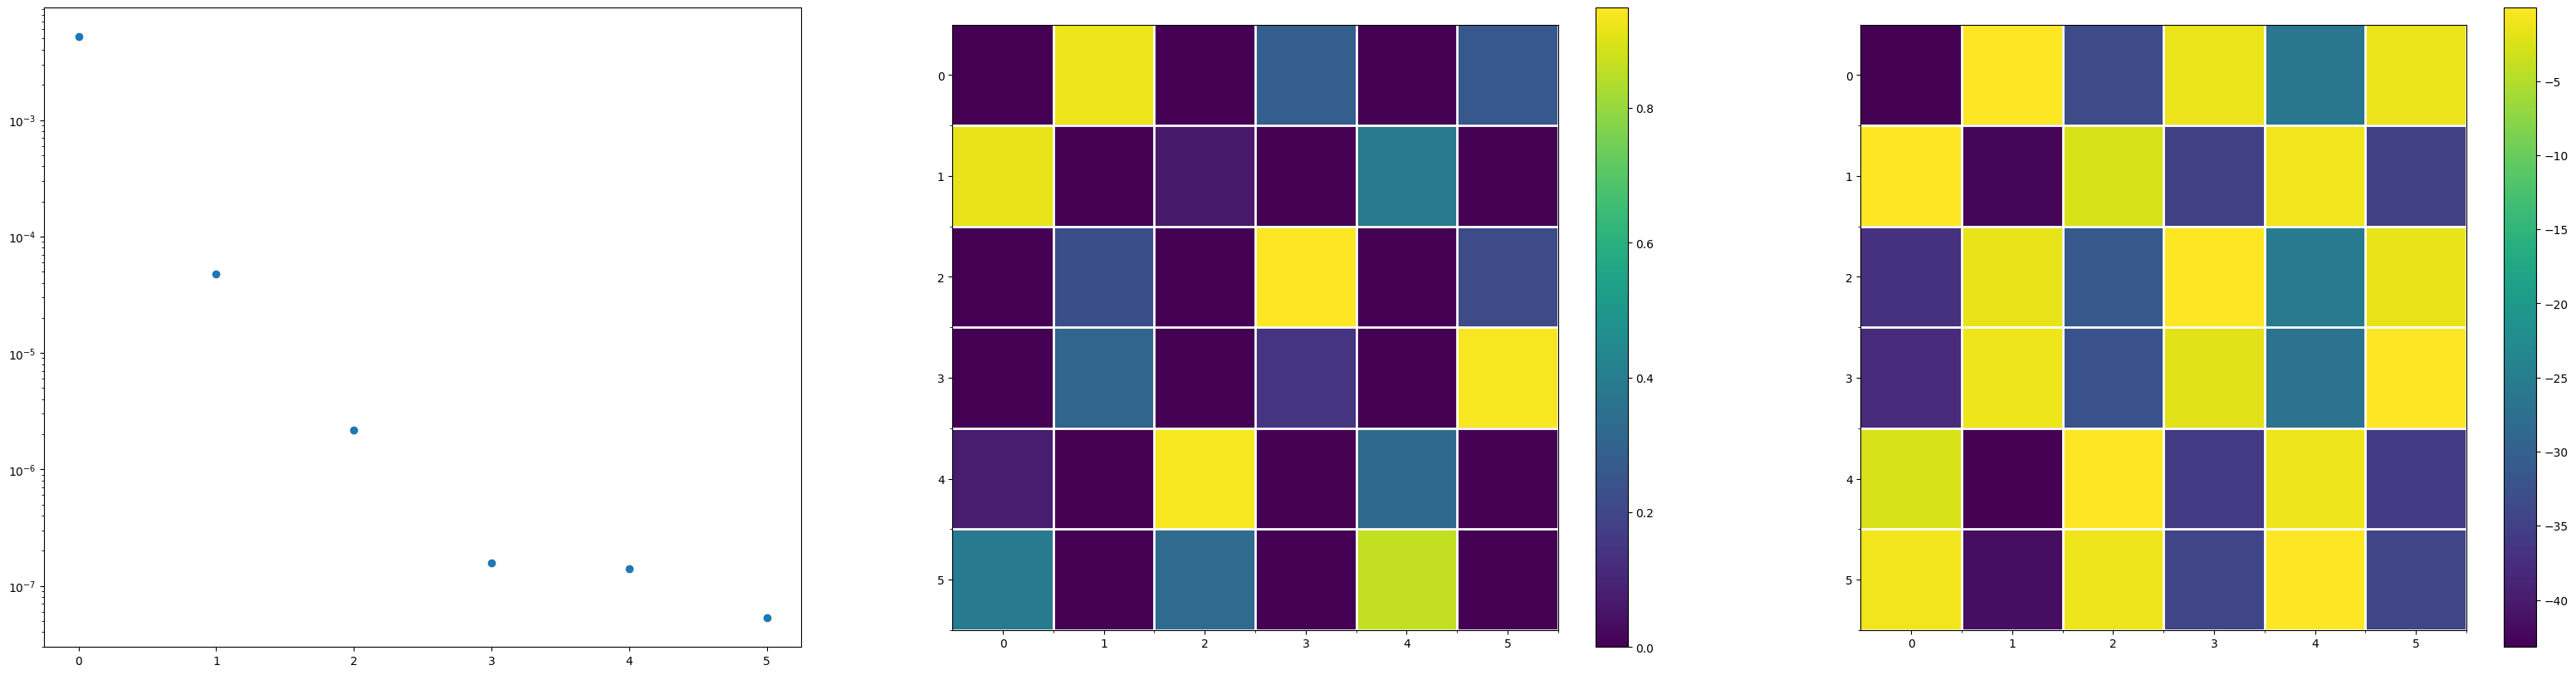

In [20]:
eigvals, eigvecs = np.linalg.eig(F)

eigvecs = eigvecs[:,np.argsort(eigvals)[::-1]]
eigvals = eigvals[np.argsort(eigvals)[::-1]]

plt.subplots(1, 3, figsize=(40,10))
plt.subplot(1, 3, 1)
plt.plot(eigvals, "o")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.imshow(np.abs(eigvecs))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.subplot(1, 3, 3)
plt.imshow(np.log(np.abs(eigvecs)))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.show()

/tmp/ipykernel_4066/3687873738.py:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(Freg))


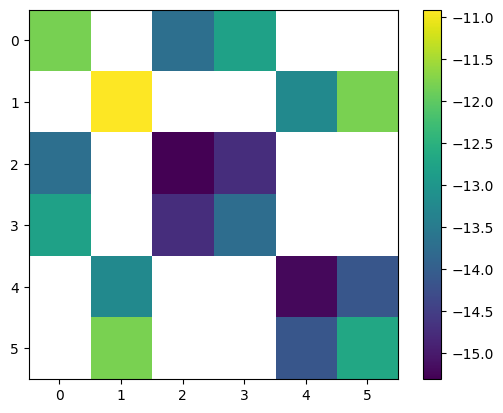

In [21]:
Sreg = np.expand_dims(glv_time(t, y, preg)-dydt, axis=-1)*glv_jac_time(t, y, preg)
Sreg = np.concatenate(Sreg, 0)
Freg = Sreg.T@Sreg
plt.imshow(np.log(Freg))
plt.colorbar()

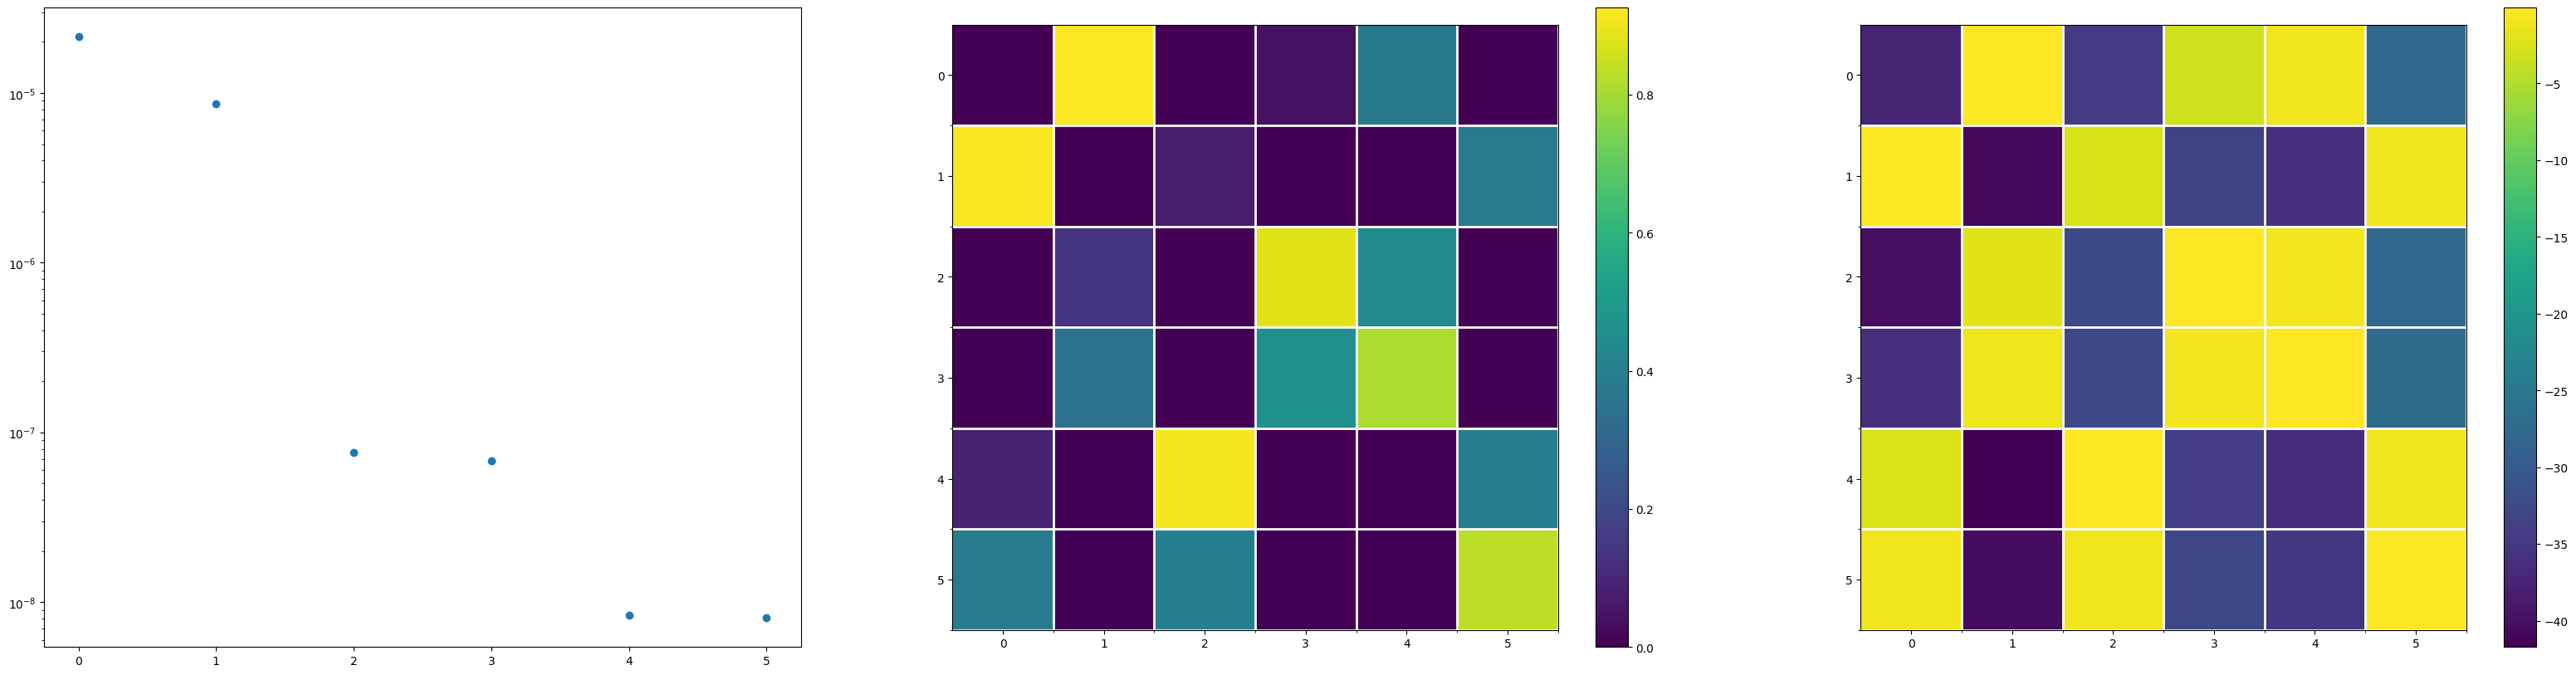

In [22]:
eigvals, eigvecs = np.linalg.eig(Freg)

eigvecs = eigvecs[:,np.argsort(eigvals)[::-1]]
eigvals = eigvals[np.argsort(eigvals)[::-1]]

plt.subplots(1, 3, figsize=(40,10))
plt.subplot(1, 3, 1)
plt.plot(eigvals, "o")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.imshow(np.abs(eigvecs))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.subplot(1, 3, 3)
plt.imshow(np.log(np.abs(eigvecs)))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.show()

/tmp/ipykernel_4066/748564111.py:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(F4))


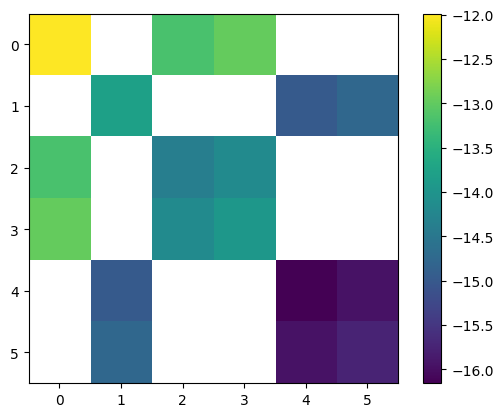

In [23]:
S4 = np.expand_dims(glv_time(t, y, p_lm[0])-dydt, axis=-1)*glv_jac_time(t, y, p_lm[0])
S4 = np.concatenate(S4, 0)
F4 = S4.T@S4
plt.imshow(np.log(F4))
plt.colorbar()

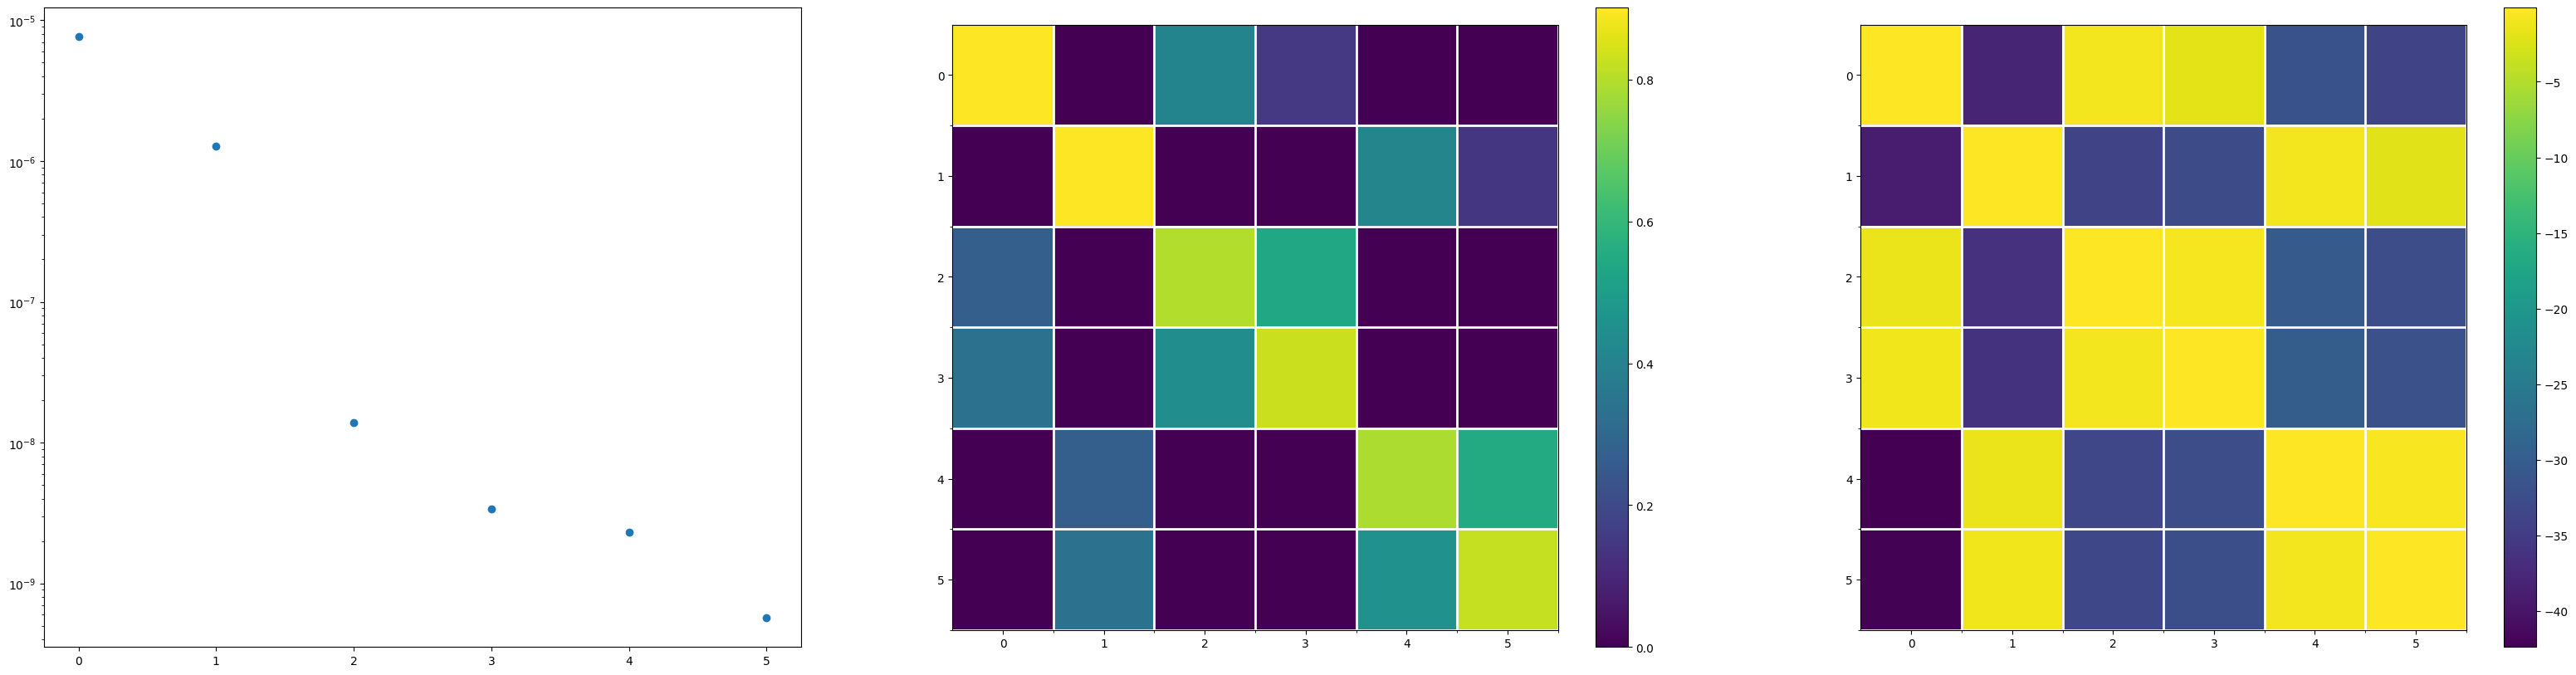

In [24]:
eigvals, eigvecs = np.linalg.eig(F4)

eigvecs = eigvecs[:,np.argsort(eigvals)[::-1]]
eigvals = eigvals[np.argsort(eigvals)[::-1]]

plt.subplots(1, 3, figsize=(40,10))
plt.subplot(1, 3, 1)
plt.plot(eigvals, "o")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.imshow(np.abs(eigvecs))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.subplot(1, 3, 3)
plt.imshow(np.log(np.abs(eigvecs)))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.show()

In [25]:
np.abs(F-Freg).sum()

0.00991866801090947

In [26]:
np.abs(F-F4).sum()

0.009957179093202975

In [27]:
p[n:].reshape((n,n))

array([[-2.09290788, -0.5557303 ],
       [ 1.96578057, -2.28174615]])

In [28]:
preg[n:].reshape((n,n))

array([[-1.77730684,  0.27816541],
       [ 0.59855352, -1.31599033]])

In [29]:
p_lm[0][n:].reshape((n,n))

array([[-2.88105418,  0.9094959 ],
       [ 0.5097958 , -1.30688066]])

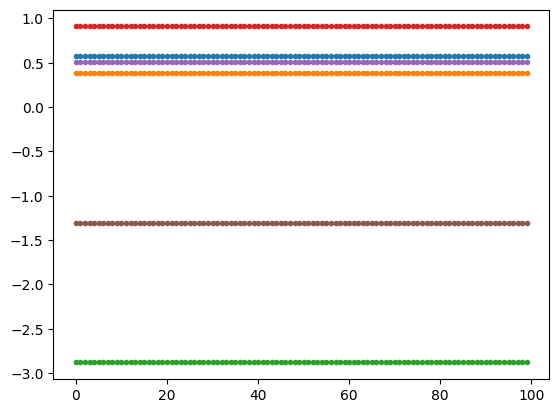

In [30]:
plt.plot(p_lm, ".")

In [31]:
mse(sol_reg, y)

0.0005442733710787013

In [32]:
mse(sol3, y)

0.00040255661927589975